# **Modelamiento**
---
- **Nombre del proyecto**: Detección de diabetes a partir de información médica y análisis de laboratorio
- **Elaborado por:** Pedro Alejandro Astaiza Perafán

In [38]:
import numpy as np
import pandas as pd
from sklearn import preprocessing, model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


## **1. Cargue de datos**
---

In [2]:
datos =  pd.read_csv('C:/Users/peast/Documents/MlOps/diabetesPrediccion/data/Dataset_process.csv')
X = datos.drop(['N','Y','P'],axis=1).values
Y = datos[['N','Y','P']].values

In [3]:
onehot = joblib.load(r'C:\Users\peast\Documents\MlOps\diabetesPrediccion\scripts\Preprocesamiento\artefactos\onehot_clase.sav')
Y_deco = onehot.inverse_transform(Y)

## **2. División en Test y entrenamiento**
---
Dado que en algunos modelos se necesitan las etiquetas como onehot encoding y otros no, se van a decodificar los valores de Y.

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    Y_deco,
                                                                    random_state=1234,
                                                                    test_size=0.2,
                                                                    stratify=Y_deco)

In [5]:
print(f'X_train: {X_train.shape}  X_test: {X_test.shape}  y_test: {y_test.shape}  y_train: {y_train.shape}')

X_train: (800, 11)  X_test: (200, 11)  y_test: (200, 1)  y_train: (800, 1)


In [6]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 82, 1: 675, 2: 43}

## **3. Análisis de Componentes Principales (PCA)**
---

In [7]:
def cumulative_explained_variance_plot(expl_variance):
  cum_var_exp = np.cumsum(expl_variance)
  plt.figure(dpi = 100, figsize = (10, 10))
  plt.title('Curva acumulativa de la varianza explicada VS n° de componentes principales', 
            fontdict= dict(family ='serif', size = 16))
  plt.xlabel('Número de componentes principales',
             fontdict= dict(family ='serif', size = 14))
  plt.ylabel('Varianza explicada acumulativa',
             fontdict= dict(family ='serif', size = 14))  
  nc = np.arange(1, expl_variance.shape[0] + 1)
  plt.plot(nc, cum_var_exp, '--r')
  plt.plot(nc, cum_var_exp, 'b*', ms = 5)   
  plt.grid()
  plt.savefig(r'C:\Users\peast\Documents\MlOps\diabetesPrediccion\documents\Modelamiento\imagenes\pca.png')
  plt.show()

In [8]:
pca = PCA(n_components=11)
pca.fit(X_train)
X_t = pca.transform(X)

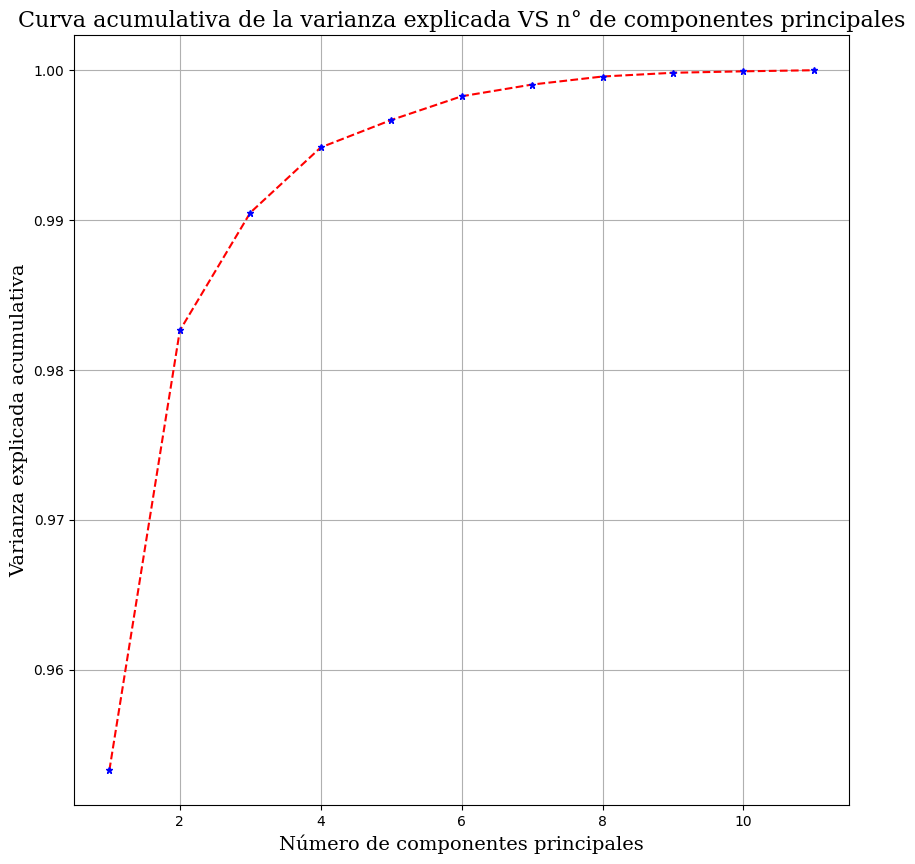

In [9]:
cumulative_explained_variance_plot(pca.explained_variance_ratio_)

In [10]:
pca_final = PCA(n_components=6)
pca_final.fit(X=X_train)
joblib.dump(pca_final,r'C:\Users\peast\Documents\MlOps\diabetesPrediccion\scripts\Preprocesamiento\artefactos\pca.sav')
X_pca = pca_final.transform(X=X_train)

## **4. Modelamiento**
---

### **4.1. Regresión logística sin pesos ponderados (modelo base)**

In [75]:
base = LogisticRegression()
base.fit(X_pca,y_train.ravel())

c:\Users\peast\Documents\MlOps\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [76]:
joblib.dump(base,r'C:\Users\peast\Documents\MlOps\diabetesPrediccion\scripts\Modelamiento\artefactos\regresion_logistica_base.sav')

['C:\\Users\\peast\\Documents\\MlOps\\diabetesPrediccion\\scripts\\Modelamiento\\artefactos\\regresion_logistica_base.sav']

In [77]:
predict = base.predict(pca_final.transform(X_test))
print(classification_report(y_true=y_test,y_pred=predict))
with open(r'C:\Users\peast\Documents\MlOps\diabetesPrediccion\documents\Modelamiento\metrics.csv','a+',encoding='utf-8') as metrics:
    metrics.write(f'\nModelo base,{accuracy_score(y_true=y_test,y_pred=predict)},{f1_score(y_true=y_test,y_pred=predict,average="macro")}')

              precision    recall  f1-score   support

           0       0.70      0.90      0.79        21
           1       0.94      0.96      0.95       169
           2       0.00      0.00      0.00        10

    accuracy                           0.91       200
   macro avg       0.55      0.62      0.58       200
weighted avg       0.87      0.91      0.89       200



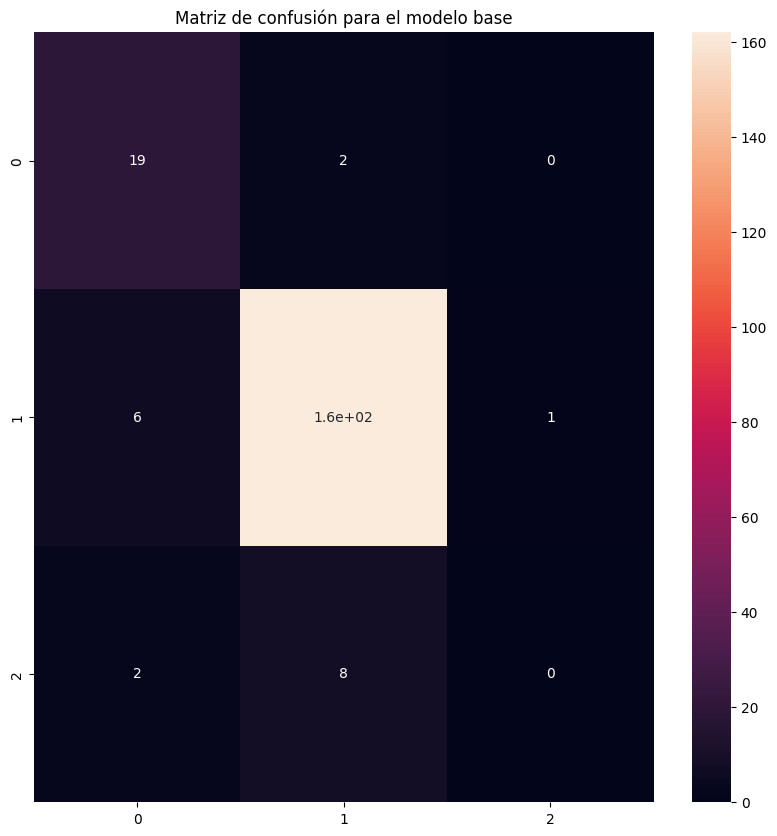

In [79]:
fig,ax = plt.subplots(figsize=(10,10))
sns.heatmap(confusion_matrix(y_true=y_test,y_pred=predict),ax=ax,annot=True)
ax.set_title('Matriz de confusión para el modelo base')
plt.savefig(r'C:\Users\peast\Documents\MlOps\diabetesPrediccion\documents\Modelamiento\imagenes\Base.png')
plt.show()

### **4.2. Regresión logística con ponderación de pesos**

In [11]:
class_weight = {
    0:(82+675+42)/(3*82),
    1:(82+675+42)/(3*675),
    2:(82+675+42)/(3*43)
}
class_weight

{0: 3.247967479674797, 1: 0.3945679012345679, 2: 6.1937984496124034}

In [12]:
hiperparametros = {
    'penalty':['l1','l2','elastinet'],
    'fit_intercept':[True,False]
    }

In [13]:
modelo_regresion = LogisticRegression(random_state=1234,
                                      class_weight=class_weight)
grid = GridSearchCV(estimator=modelo_regresion,
                    param_grid=hiperparametros,
                    cv=5,
                    verbose=1)
grid.fit(X=X_pca,y=y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


c:\Users\peast\Documents\MlOps\.venv\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\peast\Documents\MlOps\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\peast\Documents\MlOps\.venv\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape o

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight={0: 3.247967479674797,
                                                        1: 0.3945679012345679,
                                                        2: 6.1937984496124034},
                                          random_state=1234),
             param_grid={'fit_intercept': [True, False],
                         'penalty': ['l1', 'l2', 'elastinet']},
             verbose=1)

In [16]:
modelo_mejor = grid.best_estimator_
modelo_mejor

LogisticRegression(class_weight={0: 3.247967479674797, 1: 0.3945679012345679,
                                 2: 6.1937984496124034},
                   random_state=1234)

In [43]:
joblib.dump(modelo_mejor,r'C:\Users\peast\Documents\MlOps\diabetesPrediccion\scripts\Modelamiento\artefactos\regresion_logistica.sav')

['C:\\Users\\peast\\Documents\\MlOps\\diabetesPrediccion\\scripts\\Modelamiento\\artefactos\\regresion_logistica.sav']

In [18]:
predict = modelo_mejor.predict(pca_final.transform(X_test))
print(classification_report(y_true=y_test, y_pred=predict))

              precision    recall  f1-score   support

           0       0.70      0.90      0.79        21
           1       0.99      0.94      0.96       169
           2       0.50      0.60      0.55        10

    accuracy                           0.92       200
   macro avg       0.73      0.82      0.77       200
weighted avg       0.93      0.92      0.92       200



In [26]:
accuracy_score(y_true=y_test,y_pred=predict)
f1_score(y_true=y_test,y_pred=predict,average='macro')

0.7669191919191919

In [36]:
with open(r'C:\Users\peast\Documents\MlOps\diabetesPrediccion\documents\Modelamiento\metrics.csv','a+',encoding='utf-8') as metrics:
    metrics.write(f'\nregresión logística,{accuracy_score(y_true=y_test,y_pred=predict)},{f1_score(y_true=y_test,y_pred=predict,average="macro")}')

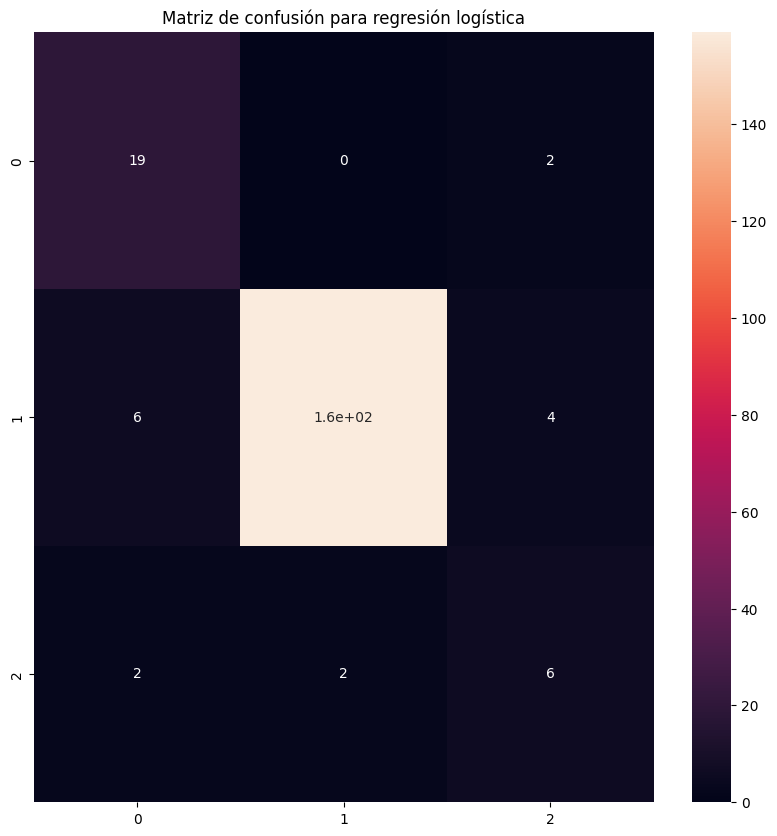

In [20]:
fig,ax = plt.subplots(figsize=(10,10))
sns.heatmap(confusion_matrix(y_true=y_test,y_pred=predict),ax=ax,annot=True)
ax.set_title('Matriz de confusión para regresión logística')
plt.savefig(r'C:\Users\peast\Documents\MlOps\diabetesPrediccion\documents\Modelamiento\imagenes\RL.png')
plt.show()


### **4.3. Decision Tree**

In [47]:
hiperparametros = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['random','best'],
    'max_depth': np.arange(10,1000,10)
}

In [48]:
arbol = DecisionTreeClassifier(random_state=1234)
grid_arbol = GridSearchCV(estimator=arbol,
                          param_grid=hiperparametros,
                          cv=10,
                          verbose=1)
grid_arbol.fit(X=X_pca, y=y_train)

Fitting 10 folds for each of 594 candidates, totalling 5940 fits


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=1234),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260,
       270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390,
       400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520,
       530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650,
       660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780,
       790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900, 910,
       920, 930, 940, 950, 960, 970, 980, 990]),
                         'splitter': ['random', 'best']},
             verbose=1)

In [49]:
modelo_mejor = grid_arbol.best_estimator_
modelo_mejor

DecisionTreeClassifier(max_depth=20, random_state=1234)

In [50]:
joblib.dump(modelo_mejor,r'C:\Users\peast\Documents\MlOps\diabetesPrediccion\scripts\Modelamiento\artefactos\decision_tree.sav')

['C:\\Users\\peast\\Documents\\MlOps\\diabetesPrediccion\\scripts\\Modelamiento\\artefactos\\decision_tree.sav']

In [52]:
predict = modelo_mejor.predict(pca_final.transform(X_test))
print(classification_report(y_true=y_test,y_pred=predict))
with open(r'C:\Users\peast\Documents\MlOps\diabetesPrediccion\documents\Modelamiento\metrics.csv','a+',encoding='utf-8') as metrics:
    metrics.write(f'\nÁrbol de decisión,{accuracy_score(y_true=y_test,y_pred=predict)},{f1_score(y_true=y_test,y_pred=predict,average="macro")}')

              precision    recall  f1-score   support

           0       0.76      0.76      0.76        21
           1       0.98      0.96      0.97       169
           2       0.69      0.90      0.78        10

    accuracy                           0.94       200
   macro avg       0.81      0.87      0.84       200
weighted avg       0.94      0.94      0.94       200



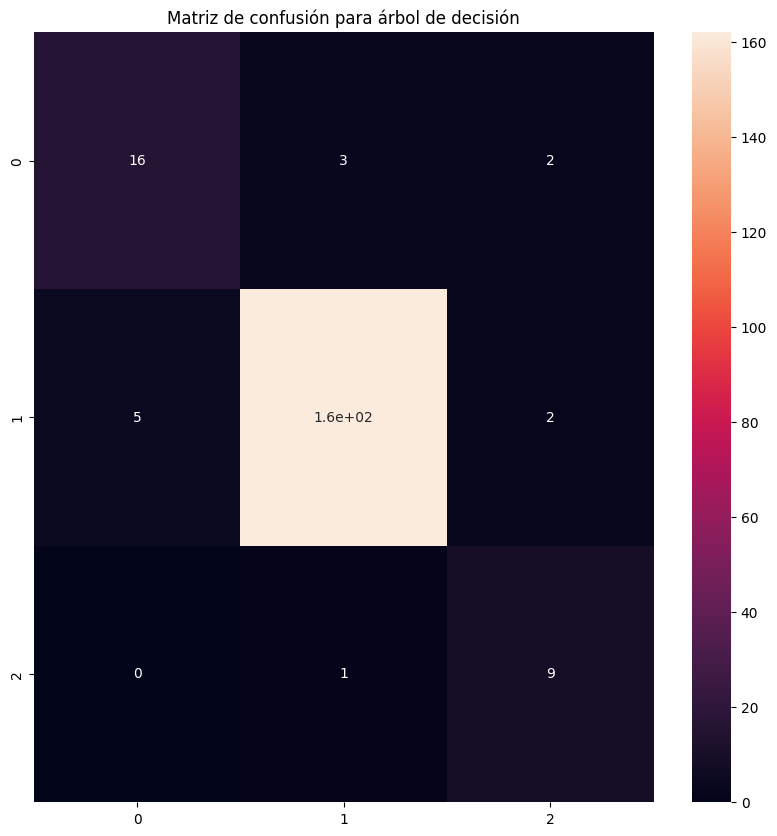

In [54]:
fig,ax = plt.subplots(figsize=(10,10))
sns.heatmap(confusion_matrix(y_true=y_test,y_pred=predict),ax=ax,annot=True)
ax.set_title('Matriz de confusión para árbol de decisión')
plt.savefig(r'C:\Users\peast\Documents\MlOps\diabetesPrediccion\documents\Modelamiento\imagenes\DT.png')
plt.show()

### **4.4. Random Forest** 

In [66]:
class_weight = {
    0:(82+675+42)/(3*82),
    1:(82+675+42)/(3*675),
    2:(82+675+42)/(3*43)
}
class_weight
hiperparametros = {
    'n_estimators': np.arange(100,1000,100),
    'max_depth': np.arange(10,1000,50) 
}

In [68]:
random_forest = RandomForestClassifier(class_weight=class_weight,random_state=1234)
grid_bosque = GridSearchCV(estimator=random_forest,
                           param_grid=hiperparametros,
                           cv=5,
                           verbose=1)
grid_bosque.fit(X=X_pca,y=y_train.ravel())

Fitting 5 folds for each of 180 candidates, totalling 900 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight={0: 3.247967479674797,
                                                            1: 0.3945679012345679,
                                                            2: 6.1937984496124034},
                                              random_state=1234),
             param_grid={'max_depth': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960]),
                         'n_estimators': array([100, 200, 300, 400, 500, 600, 700, 800, 900])},
             verbose=1)

In [69]:
modelo_mejor = grid_bosque.best_estimator_
modelo_mejor

RandomForestClassifier(class_weight={0: 3.247967479674797,
                                     1: 0.3945679012345679,
                                     2: 6.1937984496124034},
                       max_depth=10, n_estimators=300, random_state=1234)

In [70]:
joblib.dump(modelo_mejor,r'C:\Users\peast\Documents\MlOps\diabetesPrediccion\scripts\Modelamiento\artefactos\random_forest.sav')

['C:\\Users\\peast\\Documents\\MlOps\\diabetesPrediccion\\scripts\\Modelamiento\\artefactos\\random_forest.sav']

In [71]:
predict = modelo_mejor.predict(pca_final.transform(X_test))
print(classification_report(y_true=y_test,y_pred=predict))
with open(r'C:\Users\peast\Documents\MlOps\diabetesPrediccion\documents\Modelamiento\metrics.csv','a+',encoding='utf-8') as metrics:
    metrics.write(f'\nRandom Forest,{accuracy_score(y_true=y_test,y_pred=predict)},{f1_score(y_true=y_test,y_pred=predict,average="macro")}')

              precision    recall  f1-score   support

           0       0.76      0.76      0.76        21
           1       0.96      0.97      0.96       169
           2       0.75      0.60      0.67        10

    accuracy                           0.93       200
   macro avg       0.82      0.78      0.80       200
weighted avg       0.93      0.93      0.93       200



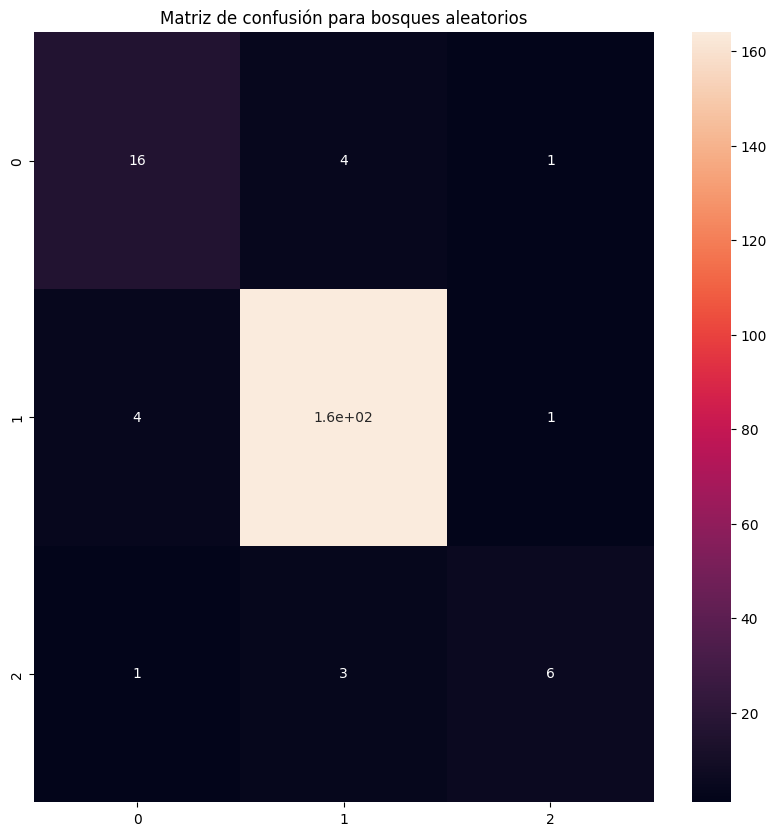

In [73]:
fig,ax = plt.subplots(figsize=(10,10))
sns.heatmap(confusion_matrix(y_true=y_test,y_pred=predict),ax=ax,annot=True)
ax.set_title('Matriz de confusión para bosques aleatorios')
plt.savefig(r'C:\Users\peast\Documents\MlOps\diabetesPrediccion\documents\Modelamiento\imagenes\RF.png')
plt.show()